# База данных «Учебная аналитика по курсу»

Структура базы данных:

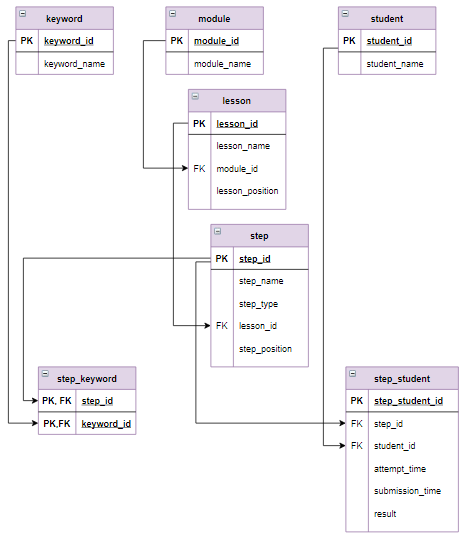

### 125

Отобрать все шаги, в которых рассматриваются вложенные запросы (то есть в названии шага упоминаются вложенные запросы). Указать к какому уроку и модулю они относятся. Для этого вывести 3 поля:

- в поле Модуль указать номер модуля и его название через пробел;  
- в поле Урок указать номер модуля, порядковый номер урока (lesson_position) через точку и название урока через пробел;  
- в поле Шаг указать номер модуля, порядковый номер урока (lesson_position) через точку, порядковый номер шага (step_position) через точку и название шага через пробел.  

Длину полей Модуль и Урок ограничить 19 символами, при этом слишком длинные надписи обозначить многоточием в конце (16 символов - это номер модуля или урока, пробел и  название Урока или Модуля к ним присоединить "..."). Информацию отсортировать по возрастанию номеров модулей, порядковых номеров уроков и порядковых номеров шагов.

Фрагмент структуры данных:

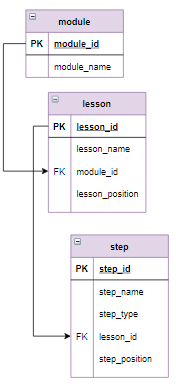

In [ ]:
SELECT IF(LENGTH(CONCAT(lesson.module_id, ' ', LEFT(module_name, 14), '...')) > 19,
          CONCAT(lesson.module_id, ' ', LEFT(module_name, 14), '...'),
          CONCAT(lesson.module_id, ' ', module_name)) AS Модуль,
       IF(LENGTH(CONCAT(lesson.module_id, '.', lesson.lesson_position, ' ', LEFT(lesson_name, 12), '...')) > 19,
          CONCAT(lesson.module_id, '.', lesson.lesson_position, ' ', LEFT(lesson_name, 12), '...'),
          CONCAT(lesson.module_id, '.', lesson.lesson_position, ' ', lesson_name)) AS Урок,
       CONCAT(lesson.module_id, '.', lesson.lesson_position, '.', step_position, ' ', step_name) AS Шаг
  FROM module JOIN lesson
       ON module.module_id = lesson.module_id
       JOIN step 
       ON lesson.lesson_id = step.lesson_id
 WHERE step_name LIKE '%ложенн%'
 ORDER BY Модуль, Урок, Шаг

### 126

Заполнить таблицу step_keyword следующим образом: если ключевое слово есть в названии шага, то включить в step_keyword строку с id шага и id ключевого слова. 

Фрагмент структуры данных:

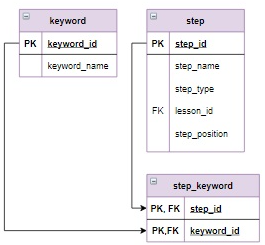

In [ ]:
INSERT INTO step_keyword(step_id, keyword_id)
SELECT step_id, 
       keyword_id
  FROM keyword CROSS JOIN step
 WHERE REGEXP_INSTR(step_name, concat('\\b', keyword_name, '\\b'));

SELECT *
  FROM step_keyword;

### 127

Реализовать поиск по ключевым словам. Вывести шаги, с которыми связаны ключевые слова MAX и AVG одновременно. Для шагов указать id модуля, позицию урока в модуле, позицию шага в уроке через точку, после позиции шага перед заголовком - пробел. Позицию шага в уроке вывести в виде двух цифр (если позиция шага меньше 10, то перед цифрой поставить 0). Столбец назвать Шаг. Информацию отсортировать по первому столбцу в алфавитном порядке.

Фрагмент структуры данных:

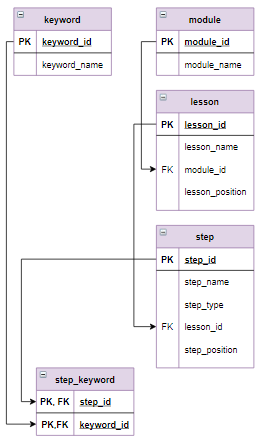

In [ ]:
SELECT CONCAT(module_id, '.', lesson_position, IF(step_position < 10, ".0","."), step_position, " ", step_name) AS Шаг
  FROM step JOIN lesson USING(lesson_id)
       JOIN module USING(module_id)
       JOIN step_keyword USING (step_id)
       JOIN keyword USING(keyword_id)
 WHERE keyword_name = 'MAX' 
       OR keyword_name ='AVG'
 GROUP BY ШАГ
HAVING COUNT(*) = 2
 ORDER BY 1

### 128 Выборка данных по нескольким условиям, оператор CASE

Посчитать, сколько студентов относится к каждой группе. Столбцы назвать Группа, Интервал, Количество. Указать границы интервала.

Фрагмент структуры данных:

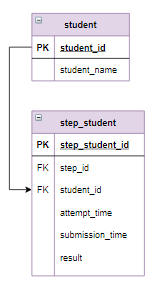

In [ ]:
SELECT Группа, 
       CASE WHEN Группа = 'I' THEN 'от 0 до 10'
       WHEN Группа = 'II' THEN 'от 11 до 15'
       WHEN Группа = 'III' THEN 'от 16 до 27'
       ELSE 'больше 27' END AS Интервал, 
       COUNT(*) AS Количество
  FROM (SELECT student_name, 
               rate,
               CASE WHEN rate <= 10 THEN "I"
               WHEN rate <= 15 THEN "II"
               WHEN rate <= 27 THEN "III"
               ELSE "IV"
               END AS Группа
          FROM (SELECT student_name, 
                       COUNT(*) AS rate
                  FROM (SELECT student_name, 
                               step_id
                          FROM student JOIN step_student
                               ON student.student_id = step_student.student_id
                         WHERE result = 'correct'
                         GROUP BY student_name, step_id
                        ) AS sq1
         GROUP BY student_name
               ) AS sq2
       ) AS sq3
 GROUP BY Группа
 ORDER BY Группа

### 129 Табличные выражения, оператор WITH

Для каждого шага вывести процент правильных решений. Для шагов, которые  не имеют неверных ответов,  указать 100 как процент успешных попыток, если же шаг не имеет верных ответов, указать 0. Информацию отсортировать сначала по возрастанию успешности, а затем по названию шага в алфавитном порядке.

Фрагмент структуры данных:

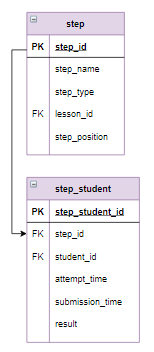

In [ ]:
WITH get_count_correct (st_n_c, count_correct) 
     AS (SELECT step_name, 
                COUNT(*)
           FROM step JOIN step_student USING (step_id)
          WHERE result = "correct"
          GROUP BY step_name),
     get_count_wrong (st_n_w, count_wrong) 
     AS (SELECT step_name, 
                COUNT(*)
           FROM step JOIN step_student USING (step_id)
          WHERE result = "wrong"
          GROUP BY step_name)  
   
SELECT st_n_c AS Шаг,
       CASE WHEN ROUND(count_correct / (count_correct + count_wrong) * 100) IS NULL THEN 100
       ELSE ROUND(count_correct / (count_correct + count_wrong) * 100)
       END AS Успешность
  FROM  get_count_correct LEFT JOIN get_count_wrong ON st_n_c = st_n_w
 UNION
SELECT st_n_w AS Шаг,
       CASE WHEN ROUND(count_correct / (count_correct + count_wrong) * 100) IS NULL THEN 0
       ELSE ROUND(count_correct / (count_correct + count_wrong) * 100)
       END AS Успешность
  FROM get_count_correct RIGHT JOIN get_count_wrong ON st_n_c = st_n_w
 ORDER BY Успешность, Шаг

### 130

Вычислить прогресс пользователей по курсу. Прогресс вычисляется как отношение верно пройденных шагов к общему количеству шагов в процентах, округленное до целого. В нашей базе данные о решениях занесены не для всех шагов, поэтому общее количество шагов определить как количество различных шагов в таблице step_student.

Тем пользователям, которые прошли все шаги (прогресс = 100%) выдать "Сертификат с отличием". Тем, у кого прогресс больше или равен 80% -  "Сертификат". Для остальных записей в столбце Результат задать пустую строку ("").

Информацию отсортировать по убыванию прогресса, затем по имени пользователя в алфавитном порядке.

Фрагмент структуры данных:

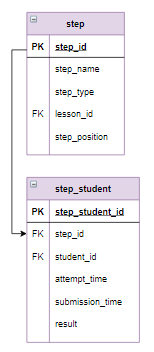

In [ ]:
SET @max_progress = (SELECT COUNT(DISTINCT step_id) FROM step_student);

SELECT student_name AS Студент, 
       Прогресс,
       CASE WHEN Прогресс = 100 THEN 'Сертификат с отличием'
       WHEN Прогресс >= 80 THEN 'Сертификат'
       ELSE '' END AS Результат
  FROM (SELECT student_name, 
               ROUND(100 * (COUNT(DISTINCT step_id) / @max_progress)) AS Прогресс
          FROM student JOIN step_student
               ON student.student_id = step_student.student_id
         WHERE result = 'correct'
         GROUP BY student_name) AS sq
 ORDER BY Прогресс DESC, 
          Студент

### 131 Оконные функции, оператор OVER, ORDER BY

Для студента с именем student_61 вывести все его попытки: название шага, результат и дату отправки попытки (submission_time). Информацию отсортировать по дате отправки попытки и указать, сколько минут прошло между отправкой соседних попыток. Название шага ограничить 20 символами и добавить "...". Столбцы назвать Студент, Шаг, Результат, Дата_отправки, Разница.

Фрагмент структуры данных:

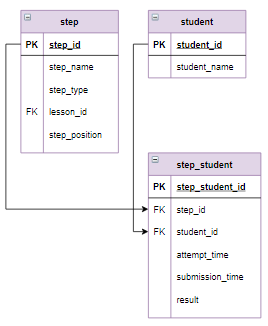

In [ ]:
SELECT student_name AS Студент, 
       IF(LENGTH(step_name) >= 20, CONCAT(LEFT(step_name, 20), '...'), step_name)  AS Шаг, 
       result AS Результат, 
       FROM_UNIXTIME(submission_time) AS Дата_отправки,
       SEC_TO_TIME(submission_time - LAG(submission_time, 1, submission_time) 
       OVER (ORDER BY submission_time)) AS Разница
  FROM step JOIN step_student
       ON step.step_id = step_student.step_id
       JOIN student
       ON student.student_id = step_student.student_id
 WHERE student_name = 'student_61'
 ORDER BY Дата_отправки

### 132

Посчитать среднее время, за которое пользователи проходят урок по следующему алгоритму:

- для каждого пользователя вычислить время прохождения шага как сумму времени, потраченного на каждую попытку (время попытки - это разница между временем отправки задания и временем начала попытки), при этом попытки, которые длились больше 4 часов не учитывать, так как пользователь мог просто оставить задание открытым в браузере, а вернуться к нему на следующий день;  
- для каждого студента посчитать общее время, которое он затратил на каждый урок;
- вычислить среднее время выполнения урока в часах, результат округлить до 2-х знаков после запятой;  
- вывести информацию по возрастанию времени, пронумеровав строки, для каждого урока указать номер модуля и его позицию в нем.  
Столбцы результата назвать Номер, Урок, Среднее_время.

Фрагмент структуры данных:

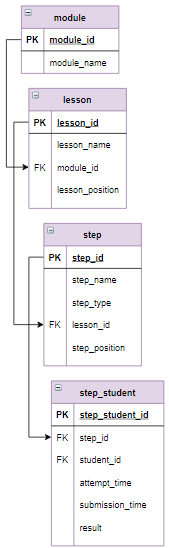

WITH t1 AS (SELECT student_id, 
                   step_name, 
                   lesson_name,
                   SUM(submission_time - attempt_time) AS Время_на_шаг
              FROM module JOIN lesson
                   ON module.module_id = lesson.module_id
                   JOIN step
                   ON lesson.lesson_id = step.lesson_id
                   JOIN step_student
                   ON step.step_id = step_student.step_id
             WHERE submission_time - attempt_time < 4 * 3600
             GROUP BY student_id, step_name, lesson_name),
     t2 AS (SELECT student_id, 
                   lesson_name, 
                   SUM(Время_на_шаг) AS Время_на_урок
                   FROM t1
             GROUP BY student_id, lesson_name),
     t3 AS (SELECT lesson_name, 
                   ROUND(AVG(Время_на_урок) / 3600, 2) AS Среднее_время
              FROM t2
             GROUP BY lesson_name)

SELECT ROW_NUMBER() OVER (ORDER BY Среднее_время) AS Номер, 
       CONCAT(module.module_id, '.', lesson_position, ' ', t3.lesson_name) AS Урок, 
       Среднее_время
  FROM t3 JOIN lesson
       ON t3.lesson_name = lesson.lesson_name
       JOIN module
       ON lesson.module_id = module.module_id
 ORDER BY Среднее_время 

### 133 Оконные функции, оператор OVER, PARTITION BY

Вычислить рейтинг каждого студента относительно студента, прошедшего наибольшее количество шагов в модуле (вычисляется как отношение количества пройденных студентом шагов к максимальному количеству пройденных шагов, умноженное на 100). Вывести номер модуля, имя студента, количество пройденных им шагов и относительный рейтинг. Относительный рейтинг округлить до одного знака после запятой. Столбцы назвать Модуль, Студент, Пройдено_шагов и Относительный_рейтинг  соответственно. Информацию отсортировать сначала по возрастанию номера модуля, потом по убыванию относительного рейтинга и, наконец, по имени студента в алфавитном порядке.

Фрагмент структуры данных:

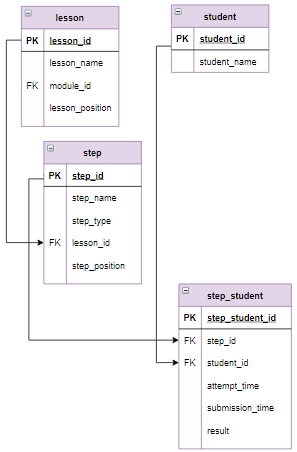

In [ ]:
WITH t1 AS (SELECT module_id AS Модуль, 
                   student_name AS Студент, 
                   COUNT(DISTINCT step.step_id) AS Пройдено_шагов
              FROM student JOIN step_student
                   ON student.student_id = step_student.student_id
                   JOIN step
                   ON step.step_id = step_student.step_id
                   JOIN lesson 
                   ON lesson.lesson_id = step.lesson_id
             WHERE result = "correct"
             GROUP BY module_id, student_name)
SELECT Модуль, 
       Студент, 
       Пройдено_шагов,
       ROUND(100 * (Пройдено_шагов / MAX(Пройдено_шагов) OVER (PARTITION BY Модуль)), 1) AS Относительный_рейтинг
  FROM t1
 ORDER BY Модуль, Относительный_рейтинг DESC, Студент

### 134

Проанализировать, в каком порядке и с каким интервалом пользователь отправлял последнее верно выполненное задание каждого урока. В базе занесены попытки студентов  для трех уроков курса, поэтому анализ проводить только для этих уроков.

Для студентов прошедших как минимум по одному шагу в каждом уроке, найти последний пройденный шаг каждого урока - крайний шаг, и указать:

- имя студента;  
- номер урока, состоящий из номера модуля и через точку позиции каждого урока в модуле;  
- время отправки  - время подачи решения на проверку;  
- разницу во времени отправки между текущим и предыдущим крайним шагом в днях, при этом для первого шага поставить прочерк ("-"), а количество дней округлить до целого в большую сторону. 

Столбцы назвать  Студент, Урок,  Макс_время_отправки и Интервал  соответственно. Отсортировать результаты по имени студента в алфавитном порядке, а потом по возрастанию времени отправки.

Фрагмент структуры данных:

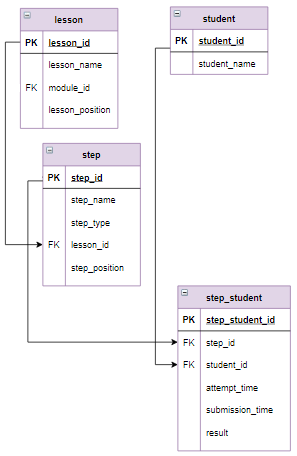

In [ ]:
WITH t1 AS(SELECT student_name
            FROM student JOIN step_student
                 ON student.student_id = step_student.student_id
                 JOIN step
                 ON step_student.step_id = step.step_id
                 JOIN lesson
                 ON step.lesson_id = lesson.lesson_id
           WHERE result = 'correct'
           GROUP BY student_name, module_id, lesson_position),

     t2 AS(SELECT *
             FROM t1
            GROUP BY student_name
           HAVING COUNT(*) = 3),

     t3 AS (SELECT student_name, 
                   module_id, 
                   lesson_position, 
                   attempt_time, 
                   submission_time 
              FROM student JOIN step_student
                   ON student.student_id = step_student.student_id
                   JOIN step
                   ON step_student.step_id = step.step_id
                   JOIN lesson
                   ON step.lesson_id = lesson.lesson_id
             WHERE student_name IN (SELECT * 
                                      FROM t2) 
                   AND result = 'correct'),

     t4 AS (SELECT student_name, 
                   module_id, 
                   lesson_position, 
                   MAX(submission_time) AS Макс_время
              FROM t3
             GROUP BY student_name, module_id, lesson_position
             ORDER BY student_name, Макс_время)

SELECT student_name AS Студент, 
       CONCAT(module_id, '.', lesson_position) AS Урок, 
       FROM_UNIXTIME(Макс_время) AS Макс_время_отправки,
       IF(CEIL((Макс_время - LAG(Макс_время, 1, Макс_время)
       OVER (PARTITION BY student_name order by Макс_время)) / 86400) = 0, '-',
       CEIL((Макс_время - LAG(Макс_время, 1, Макс_время)
       OVER (PARTITION BY student_name order by Макс_время)) / 86400)) AS Интервал
FROM t4

### 135

Для студента с именем student_59 вывести следующую информацию по всем его попыткам:

- информация о шаге: номер модуля, символ '.', позиция урока в модуле, символ '.', позиция шага в модуле;  
- порядковый номер попытки для каждого шага - определяется по возрастанию времени отправки попытки;  
- результат попытки;  
- время попытки (преобразованное к формату времени) - определяется как разность между временем отправки попытки и времени ее начала, в случае если попытка длилась более 1 часа, то время попытки заменить на среднее время всех попыток пользователя по всем шагам без учета тех, которые длились больше 1 часа;  
- относительное время попытки  - определяется как отношение времени попытки (с учетом замены времени попытки) к суммарному времени всех попыток  шага, округленное до двух знаков после запятой.  

Столбцы назвать  Студент,  Шаг, Номер_попытки, Результат, Время_попытки и Относительное_время. Информацию отсортировать сначала по возрастанию id шага, а затем по возрастанию номера попытки (определяется по времени отправки попытки).

Фрагмент структуры данных:

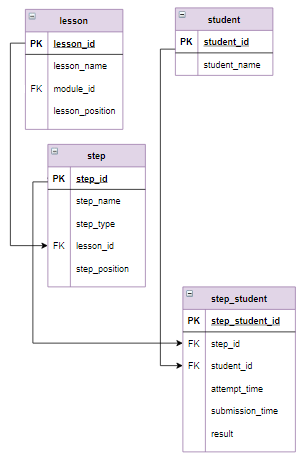

In [ ]:
SET @avg_time := (SELECT AVG(submission_time - attempt_time)
                    FROM step_student JOIN student USING(student_id)
                   WHERE student_name = "student_59" 
                         AND (submission_time - attempt_time) <= 3600);

SELECT student_name AS Студент,
       CONCAT(module_id, ".", lesson_position, ".", step_position) AS Шаг,
       ROW_NUMBER() OVER (PARTITION BY CONCAT(module_id, ".", lesson_position, ".", step_position) ORDER BY submission_time) AS Номер_попытки,
       result AS Результат,
       IF(submission_time - attempt_time <= 3600, 
          SEC_TO_TIME(submission_time - attempt_time), 
          SEC_TO_TIME(ROUND(@avg_time))) AS Время_попытки,
       ROUND(100*(IF(submission_time - attempt_time <= 3600, 
                     ROUND(submission_time - attempt_time), 
                     ROUND(@avg_time))) / SUM(IF(submission_time - attempt_time <= 3600, 
                                                 ROUND(submission_time - attempt_time), 
                                                 ROUND(@avg_time))) 
       OVER (PARTITION BY CONCAT(module_id, ".", lesson_position, ".", step_position)), 2) AS Относительное_время
  FROM student JOIN step_student
       ON student.student_id = step_student.student_id
       JOIN step
       ON step_student.step_id = step.step_id
       JOIN lesson
       ON step.lesson_id = lesson.lesson_id   
 WHERE student_name = "student_59"
 ORDER BY step_student.step_id, Номер_попытки;

### 136

Online курс обучающиеся могут проходить по различным траекториям, проследить за которыми можно по способу решения ими заданий шагов курса. Большинство обучающихся за несколько попыток  получают правильный ответ 
и переходят к следующему шагу. Но есть такие, что остаются на шаге, выполняя несколько верных попыток, или переходят к следующему, оставив нерешенные шаги.

Выделив эти "необычные" действия обучающихся, можно проследить их траекторию работы с курсом и проанализировать задания, для которых эти действия выполнялись, а затем их как-то изменить. 

Для этой цели необходимо выделить группы обучающихся по способу прохождения шагов:

- I группа - это те пользователи, которые после верной попытки решения шага делают неверную (скорее всего для того, чтобы поэкспериментировать или проверить, как работают примеры);  
- II группа - это те пользователи, которые делают больше одной верной попытки для одного шага (возможно, улучшают свое решение или пробуют другой вариант);  
- III группа - это те пользователи, которые не смогли решить задание какого-то шага (у них все попытки по этому шагу - неверные).  

Вывести группу (I, II, III), имя пользователя, количество шагов, которые пользователь выполнил по соответствующему способу. Столбцы назвать Группа, Студент, Количество_шагов. Отсортировать информацию по возрастанию номеров групп, потом по убыванию количества шагов и, наконец, по имени студента в алфавитном порядке.

Фрагмент структуры данных:

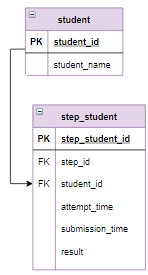

In [ ]:
WITH t1 AS(SELECT student_name, 
                  step_id, 
                  IF(result = 'correct', 1, 0) AS result, 
                  submission_time
             FROM student JOIN step_student
                  ON student.student_id = step_student.student_id),
     t2 AS(SELECT student_name, 
                  step_id, 
                  result, 
                  submission_time
             FROM student JOIN step_student
                  ON student.student_id = step_student.student_id),
     t3 AS(SELECT student_name, 
                  result, 
                  step_id,
                  LAG(result) OVER (PARTITION BY student.student_id, step_id
                  ORDER BY submission_time) AS prev_result
             FROM student JOIN step_student 
                  ON student.student_id = step_student.student_id)

SELECT 'I' AS Группа, 
       student_name AS Студент, 
       COUNT(student_name) AS Количество_шагов
  FROM t3
 WHERE (result, prev_result) = ('wrong', 'correct')
 GROUP BY student_name, result

UNION 

SELECT 'II' AS Группа, 
       student_name AS Студент, 
       COUNT(*) AS Количество_шагов
  FROM (SELECT student_name, 
               step_id, 
               SUM(result) AS Верных_решений_на_шаг 
          FROM t1
         GROUP BY student_name, step_id 
        HAVING SUM(result) > 1) AS sq
 GROUP BY student_name

UNION    
    
SELECT 'III' AS Группа, 
       student_name AS Студент, 
       COUNT(*) AS Количество_шагов
  FROM (SELECT student_name, 
               step_id
          FROM t1
         GROUP BY student_name, step_id 
        HAVING SUM(result) = 0) AS sq3
 GROUP BY student_name
 ORDER BY Группа, Количество_шагов desc, Студент